**Bitcoin Price Prediction with Machine Learning**

**Importing everything neccesary**

In [76]:
import pandas as pd
import os
import numpy as np
import requests
import time
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import Adam
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()
import prophet

**Calculating feature importance using a Random Forest Regressor which i have optimised with Grid Search**

In [8]:
data = pd.read_csv('./data/data_complete_final.csv').drop('date', axis=1)

In [105]:
data = pd.read_csv('./data/data_complete_final.csv').drop('date', axis=1)

In [108]:
print(data.columns)

Index(['open', 'close', 'close+1', 'high', 'low', 'volume_24h', 'market_cap',
       'circulating_supply', 'url_shares', 'unique_url_shares', 'tweets',
       'tweet_spam', 'tweet_sentiment1', 'tweet_sentiment2',
       'tweet_sentiment3', 'tweet_sentiment4', 'tweet_sentiment5',
       'tweet_sentiment_impact1', 'tweet_sentiment_impact2',
       'tweet_sentiment_impact3', 'tweet_sentiment_impact4',
       'tweet_sentiment_impact5', 'social_score', 'average_sentiment', 'news',
       'price_score', 'social_impact_score', 'correlation_rank',
       'galaxy_score', 'volatility', 'social_contributors', 'sma_50',
       'sma_100', 'sma_200', 'social_volume', 'market_cap_global',
       'market_dominance', 'social_volume_global', 'social_dominance',
       'Day of Month', 'month', 'Daily % Change', 'S&P 500 Daily Performance',
       'NASDAQ 100 Daily Performance', '1-Year Treasury Bond Rate',
       '5-Year Treasury Bond Rate', '10-Year Treasury Bond Rate',
       '30-Year Treasury Bond Rat

In [10]:
# Split the data into features (X) and target (y)
X = data.drop('close+1', axis=1)
y = data['close+1']

In [11]:
# Scale the features using min-max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Define the random forest model
rf = RandomForestRegressor(random_state=0)

In [13]:
# Define the hyperparameter grid to search over
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [5, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

In [14]:
# Use grid search to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_scaled, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 500, 1000]})

In [15]:
# Get the best model from the grid search
best_rf = grid_search.best_estimator_

In [16]:
# Calculate permutation importance
perm_importance = permutation_importance(best_rf, X_scaled, y, n_repeats=10, random_state=0)

In [17]:
# Calculate mean decrease impurity
mdi_importance = best_rf.feature_importances_

In [18]:
# Get feature coefficients (assuming your data is already scaled)
coef_importance = pd.Series(abs(best_rf.feature_importances_), index=X.columns)

In [19]:
# Combine the importance scores into one dataframe
imp_df = pd.DataFrame({'Permutation Importance': perm_importance.importances_mean,
                       'Mean Decrease Impurity': mdi_importance,
                       'Coefficient Importance': coef_importance})

In [20]:
# Calculate the total importance score as the mean of the three scores
imp_df['Total Importance'] = imp_df.mean(axis=1)

In [21]:
# Sort the features by total importance score
imp_df = imp_df.sort_values('Total Importance', ascending=False)

In [23]:
imp_df

,Permutation Importance,Mean Decrease Impurity,Coefficient Importance,Total Importance
close,0.446631,0.473938,0.473938,0.464835
low,0.080495,0.275102,0.275102,0.210233
market_cap,0.051445,0.072188,0.072188,0.065274
high,0.011537,0.089889,0.089889,0.063772
open,0.002133,0.038745,0.038745,0.026541
...,...,...,...,...
social_volume,0.000028,0.000035,0.000035,0.000033
social_contributors,0.000022,0.000030,0.000030,0.000028
tweets,0.000019,0.000031,0.000031,0.000027
month,0.000006,0.000010,0.000010,0.000009


In [26]:
bottom_27_index = imp_df.tail(27).index

In [27]:
#These are least important 27 features, which I will drop from the model
bottom_27_index

Index(['tweet_spam', 'tweet_sentiment2', 'Dow Jones Industrial Average Open',
       'volume_24h', 'DOGE_USD', 'url_shares', 'social_impact_score',
       'tweet_sentiment5', 'DIFF', '5-Year Treasury Bond Rate', 'ETH_USD',
       'S&P 500 Daily Performance', '1-Year Treasury Bond Rate',
       'social_score', '10-Year Treasury Bond Rate', 'tweet_sentiment4',
       'NASDAQ Composite Open', 'Bitcoin Futures Volume',
       'Dow Jones Industrial Average Close', 'price_score',
       '30-Year Treasury Bond Rate', 'S&P 500 Open', 'social_volume',
       'social_contributors', 'tweets', 'month', 'average_sentiment'],
      dtype='object')

**Predicting with the GRU Model**

In [65]:
data = pd.read_csv('./data/data_complete_final.csv').drop('date', axis=1)

In [66]:
# Drop columns with lowest importance
drop_columns = ['tweet_spam', 'tweet_sentiment2', 'Dow Jones Industrial Average Open',
       'volume_24h', 'DOGE_USD', 'url_shares', 'social_impact_score',
       'tweet_sentiment5', 'DIFF', '5-Year Treasury Bond Rate', 'ETH_USD',
       'S&P 500 Daily Performance', '1-Year Treasury Bond Rate',
       'social_score', '10-Year Treasury Bond Rate', 'tweet_sentiment4',
       'NASDAQ Composite Open', 'Bitcoin Futures Volume',
       'Dow Jones Industrial Average Close', 'price_score',
       '30-Year Treasury Bond Rate', 'S&P 500 Open', 'social_volume',
       'social_contributors', 'tweets', 'month', 'average_sentiment', 'close+1']
X = data.drop(drop_columns, axis=1)

In [67]:
y = data['close+1']

In [68]:
# Normalize features
X = (X - X.mean()) / X.std()

In [69]:
# Perform PCA to reduce dimensionality of features
pca = PCA(n_components=40)  # Specify number of principal components

In [70]:
# Fit PCA to data
X_pca = pca.fit_transform(X)

**Next I use explained variance ratios to reduce the number of features further**

In [71]:
# Calculate explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

In [72]:
# Calculate cumulative sum of explained variance ratios
cumulative_variances = np.cumsum(explained_variance_ratios)

In [73]:
# Select number of principal components that retain at least 98% of total variance
n_components = np.argmax(cumulative_variances >= 0.98) + 1

In [74]:
n_components

19

In [81]:
# Perform PCA to reduce dimensionality of features
pca = PCA(n_components=19)  # Specify number of principal components

In [82]:
# Fit PCA to data
X_pca = pca.fit_transform(X)

In [83]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [84]:
# Verify shapes of X_train and X_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1027, 19)
X_test shape: (257, 19)


In [85]:
# Verify shapes of y_train and y_test
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1027,)
y_test shape: (257,)


In [86]:
# Reshape data for use in GRU model
X_train = np.reshape(X_train, (X_train.shape[0], 1, 19))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 19))

**Setting up the GRU model**

In [87]:
# Define GRU model architecture
model = Sequential()
model.add(GRU(units=64, input_shape=(1, n_components), activation='tanh'))
model.add(Dense(units=1, activation=None))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [88]:
# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
33/33 [==============================] - 2s 17ms/step - loss: 998572992.0000 - val_loss: 976535232.0000
Epoch 2/50
33/33 [==============================] - 0s 2ms/step - loss: 998521920.0000 - val_loss: 976478592.0000
Epoch 3/50
33/33 [==============================] - 0s 2ms/step - loss: 998451456.0000 - val_loss: 976400128.0000
Epoch 4/50
33/33 [==============================] - 0s 2ms/step - loss: 998356800.0000 - val_loss: 976294720.0000
Epoch 5/50
33/33 [==============================] - 0s 2ms/step - loss: 998240000.0000 - val_loss: 976169792.0000
Epoch 6/50
33/33 [==============================] - 0s 2ms/step - loss: 998102400.0000 - val_loss: 976028928.0000
Epoch 7/50
33/33 [==============================] - 0s 2ms/step - loss: 997948864.0000 - val_loss: 975870976.0000
Epoch 8/50
33/33 [==============================] - 0s 2ms/step - loss: 997785472.0000 - val_loss: 975710656.0000
Epoch 9/50
33/33 [==============================] - 0s 2ms/step - loss: 997621184.0000 

**Calculating test statistics**

In [93]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate MAPE
mape = np.mean(np.abs((y_test.values.reshape(-1) - y_pred) / y_test.values.reshape(-1))) * 100
print('MAPE:', mape)

# Calculate MAE
mae = np.mean(np.abs(y_test.values.reshape(-1) - y_pred))
print('MAE:', mae)

# Calculate RMSE
rmse = np.sqrt(np.mean((y_test.values.reshape(-1) - y_pred)**2))
print('RMSE:', rmse)

9/9 [==============================] - 0s 1ms/step
MAPE: 99.25856272606612
MAE: 26274.481801980895
RMSE: 31147.82908648019


**Very bad results! Next attempt**

**More feature engineering**

*First I will find the variables which are least correlated with my target variable*

In [108]:
# Load your dataset into a pandas DataFrame
df = pd.read_csv('./data/data_complete_final.csv').drop('date', axis=1)

# Compute the correlation matrix between all variables and the target variable
correlations = df.corr()['close+1']


correlations_df = pd.DataFrame(correlations)
correlations_df.columns = ['correlation with close+1']
correlations_df = correlations_df.drop('close+1')  # Remove the correlation between the target and itself
correlations_df = correlations_df.sort_values(by='correlation with close+1', ascending=False)

# Filter the DataFrame to only show rows with correlation between 0.3 and -0.3
filtered_correlations = correlations_df.loc[correlations_df['correlation with close+1'].between(-0.3, 0.3)]

# Get the index of the filtered DataFrame as a list
filtered_index = filtered_correlations.index.tolist()

# Print the filtered index
print(filtered_index)


['DIFF', 'HRATE', 'price_score', 'galaxy_score', 'tweet_sentiment_impact3', 'AVBLS', 'correlation_rank', 'social_impact_score', 'tweet_sentiment3', 'Bitcoin Futures Volume', '30-Year Treasury Bond Rate', '10-Year Treasury Bond Rate', '5-Year Treasury Bond Rate', 'Bitcoin Futures Returns', 'Daily % Change', 'S&P 500 Daily Performance', 'Day of Month', 'NASDAQ 100 Daily Performance', 'volatility', 'news', 'average_sentiment', 'month']


*I will drop these columns from the dataframe*

*I am also going to drop 'circulating_supply', 'market_cap_global', 'market_cap', and 'unique_url_shares' because i believe they add no information*

*I will also drop 'open', 'close', 'high', 'low' as I know that i will keep them so i will not add them to the correlation matrix*

In [163]:
Drop = ['open', 'close', 'high', 'low','circulating_supply', 'market_cap_global', 'market_cap','unique_url_shares']

In [164]:
df = pd.read_csv('./data/data_complete_final.csv').drop('date', axis=1)

In [165]:
df = df.drop(filtered_index, axis=1)

In [166]:
df = df.drop(Drop, axis=1)

*Next i will variables that are correlated with each other (choosing the variable that is least correlated with target variable)*

In [167]:
# Compute pairwise correlations
corr_matrix = df.corr()

# Filter for correlations greater than 0.95
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

# Create new dataframe to show correlations with close+1
corr_close_plus_one = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Correlation between Variables', 'Correlation with Close+1 (Var1)', 'Correlation with Close+1 (Var2)'])
for var1, var2 in high_corr_pairs:
    corr_close_plus_one = corr_close_plus_one.append({'Variable 1': var1,
                                                      'Variable 2': var2,
                                                      'Correlation between Variables': df[var1].corr(df[var2]),
                                                      'Correlation with Close+1 (Var1)': df[var1].corr(df['close+1'].shift(-1)),
                                                      'Correlation with Close+1 (Var2)': df[var2].corr(df['close+1'].shift(-1))},
                                                     ignore_index=True)

# Sort by correlation between variables
corr_close_plus_one = corr_close_plus_one.sort_values(by='Correlation between Variables', ascending=False)

/var/folders/6b/73zmt1sx3c30hcgymp7n2zw40000gn/T/ipykernel_27007/165915255.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_close_plus_one = corr_close_plus_one.append({'Variable 1': var1,
/var/folders/6b/73zmt1sx3c30hcgymp7n2zw40000gn/T/ipykernel_27007/165915255.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_close_plus_one = corr_close_plus_one.append({'Variable 1': var1,
/var/folders/6b/73zmt1sx3c30hcgymp7n2zw40000gn/T/ipykernel_27007/165915255.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_close_plus_one = corr_close_plus_one.append({'Variable 1': var1,
/var/folders/6b/73zmt1sx3c30hcgymp7n2zw40000gn/T/ipykernel_27007/165915255.py:14: FutureWarning: The frame.append method is deprecated and 

In [168]:
corr_close_plus_one

,Variable 1,Variable 2,Correlation between Variables,Correlation with Close+1 (Var1),Correlation with Close+1 (Var2)
12,NASDAQ Composite Close,NASDAQ Composite Open,0.997806,0.888859,0.888191
4,S&P 500 Close,S&P 500 Open,0.997531,0.833698,0.832505
3,Nikkei 225 Close,Nikkei 225 Open,0.997383,0.797922,0.799603
5,US Dollar Index Close,US Dollar Index Open,0.996971,-0.367572,-0.370284
2,social_volume,tweets,0.996671,0.653861,0.634968
10,Dow Jones Industrial Average Close,Dow Jones Industrial Average Open,0.996585,0.787578,0.786709
11,Crude Oil Close,Crude Oil Open,0.993961,0.445203,0.442331
9,Dow Jones Industrial Average Close,S&P 500 Close,0.972858,0.787578,0.833698
6,Dow Jones Industrial Average Open,S&P 500 Open,0.972723,0.786709,0.832505
1,sma_100,sma_50,0.971528,0.883695,0.948094


In [169]:
# Define the columns to drop
more_cols_to_drop = ['NASDAQ Composite Open', 'S&P 500 Open', 'Nikkei 225 Close', 'Dow Jones Industrial Average Open', 'sma_100', 'US Dollar Index Close', 'Crude Oil Open']

In [170]:
# Drop the columns from the DataFrame
df = df.drop(more_cols_to_drop, axis=1)

*Next i will calculate the VIF factors of the remaining variables and drop the highest ones to reduce multicolinarity*

In [171]:
# Calculate VIF for each variable
vif_df = pd.DataFrame()
vif_df["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_df["feature"] = df.columns

# Display VIF values in a DataFrame, sorted by VIF value
vif_df = vif_df.sort_values(by='VIF Factor', ascending=False)
print(vif_df)

    VIF Factor                             feature
25  681.298313                       S&P 500 Close
26  575.071958                US Dollar Index Open
17  541.212672                       social_volume
3   530.564426                              tweets
18  269.996446                    market_dominance
29  197.589862              NASDAQ Composite Close
27  193.863504  Dow Jones Industrial Average Close
13  118.192728                        social_score
16   48.533861                             sma_200
11   48.148249             tweet_sentiment_impact4
7    47.025687                    tweet_sentiment4
22   45.129944                             ETH_USD
0    39.516838                             close+1
21   35.144767           1-Year Treasury Bond Rate
15   32.961585                              sma_50
19   32.551732                social_volume_global
24   23.515569                     Nikkei 225 Open
14   20.112525                 social_contributors
28   16.656003                 

In [172]:
cols_to_drop2 = ['social_volume', 'tweets', 'tweet_sentiment_impact4', 'US Dollar Index Open', 'S&P 500 Close', 'market_dominance', '1-Year Treasury Bond Rate', 'tweet_spam', 'url_shares', 'tweet_sentiment_impact4', 'tweet_sentiment4']

In [173]:
# Drop the columns from the DataFrame
df = df.drop(cols_to_drop2, axis=1)

In [174]:
column_names = df.columns.tolist()
column_names

['close+1',
 'volume_24h',
 'tweet_sentiment1',
 'tweet_sentiment2',
 'tweet_sentiment5',
 'tweet_sentiment_impact1',
 'tweet_sentiment_impact2',
 'tweet_sentiment_impact5',
 'social_score',
 'social_contributors',
 'sma_50',
 'sma_200',
 'social_volume_global',
 'social_dominance',
 'ETH_USD',
 'DOGE_USD',
 'Nikkei 225 Open',
 'Dow Jones Industrial Average Close',
 'Crude Oil Close',
 'NASDAQ Composite Close',
 'CPTRA']

In [177]:
columns_to_keep = [
 'date',
 'open',        
 'close',
 'close+1',
 'high', 
 'low',
 'volume_24h',
 'volume_24h',
 'tweet_sentiment1',
 'tweet_sentiment2',
 'tweet_sentiment5',
 'tweet_sentiment_impact1',
 'tweet_sentiment_impact2',
 'tweet_sentiment_impact5',
 'social_score',
 'social_contributors',
 'sma_50',
 'sma_200',
 'social_volume_global',
 'social_dominance',
 'ETH_USD',
 'DOGE_USD',
 'Nikkei 225 Open',
 'Dow Jones Industrial Average Close',
 'Crude Oil Close',
 'NASDAQ Composite Close',
 'CPTRA']

In [180]:
df = pd.read_csv('./data/data_complete_final.csv')

In [181]:
df = df[columns_to_keep]

In [183]:
#Exporting to CSV
df.to_csv('feature_engineered_data.csv', index=False)

**Support Vector Model with engineered features**

In [185]:
df = pd.read_csv('./data/feature_engineered_data.csv').drop('date', axis=1)

In [124]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('close+1', axis=1), df['close+1'], test_size=0.2, random_state=42)

In [125]:
# Perform feature selection
selector = SelectKBest(score_func=f_regression, k=12)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [126]:
# Fit the SVM model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = svm_model.predict(X_test_selected)

In [129]:
# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)
print('r2:', r2)

MSE: 311579434.5887632
MAE: 14321.804194910712
RMSE: 17651.612804182034
MAPE: 72.43836319740433
r2: -0.06547025659391337


**Next I will try Gradient Boosting Regressor**

*With all the engineered features*

In [103]:
df = pd.read_csv('./data/feature_engineered_data.csv').drop('date', axis=1)

In [102]:
""" # Separate the target variable from the features
X = df.drop('close+1', axis=1)
y = df['close+1']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model and make predictions
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test) """

" # Separate the target variable from the features\nX = df.drop('close+1', axis=1)\ny = df['close+1']\n\n# Split the data into train and test sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Fit the model and make predictions\ngb_model = GradientBoostingRegressor()\ngb_model.fit(X_train, y_train)\ny_pred = gb_model.predict(X_test) "

In [101]:
""" # Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)
print('r2:', r2) """

" # Evaluate the model performance\nmse = mean_squared_error(y_test, y_pred)\nmae = mean_absolute_error(y_test, y_pred)\nrmse = np.sqrt(mse)\nmape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100\nr2 = r2_score(y_test, y_pred)\n\nprint('MSE:', mse)\nprint('MAE:', mae)\nprint('RMSE:', rmse)\nprint('MAPE:', mape)\nprint('r2:', r2) "

*Using KBest features (8)*

In [104]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('close+1', axis=1), df['close+1'], test_size=0.2, random_state=42)

# Perform feature selection
selector = SelectKBest(score_func=f_regression, k=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train.columns[selected_indices].tolist()

# Get the scores of the selected features
feature_scores = selector.scores_[selected_indices]

# Print the selected features and their scores
print('Selected features and their scores:')
for i in range(len(selected_features)):
    print(selected_features[i], ':', feature_scores[i])
    
# Train the model
model = GradientBoostingRegressor()
model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_selected)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)
print('r2:', r2)

Selected features and their scores:
open : 110616.70187712196
close : 217393.2674346989
high : 154057.63619428882
low : 143392.29133288292
sma_50 : 9949.685771201453
MSE: 1866443.906080309
MAE: 815.7003849710175
RMSE: 1366.178577668494
MAPE: 2.883729910115222
r2: 0.993617549020351


In [281]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('close+1', axis=1), df['close+1'], test_size=0.2, random_state=42)

# Perform feature selection
selector = SelectKBest(score_func=f_regression, k=8)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train.columns[selected_indices].tolist()

# Get the scores of the selected features
feature_scores = selector.scores_[selected_indices]

# Print the selected features and their scores
print('Selected features and their scores:')
for i in range(len(selected_features)):
    print(selected_features[i], ':', feature_scores[i])
    
# Train the model
model = GradientBoostingRegressor()
model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_selected)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)
print('r2:', r2)

Selected features and their scores:
open : 110616.70187712196
close : 217393.2674346989
high : 154057.63619428882
low : 143392.29133288292
sma_50 : 9949.685771201453
ETH_USD : 4618.878756592957
NASDAQ Composite Close : 3959.6710769611177
CPTRA : 8327.650247626672
MSE: 1856455.6328829797
MAE: 816.3631006970262
RMSE: 1362.518122038375
MAPE: 2.941377748664963
r2: 0.9936517047020973


*Model which selects the optimal number of KBest features to minimise MAPE*

In [33]:
""" # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('close+1', axis=1), df['close+1'], test_size=0.2, random_state=42)

# Try different k values and select the one with the lowest MAPE
best_k = None
best_mape = float('inf')
for k in range(1, len(X_train.columns)+1):
    # Perform feature selection
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = X_train.columns[selected_indices].tolist()

    # Train the model
    model = GradientBoostingRegressor()
    model.fit(X_train_selected, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_selected)

    # Evaluate the model performance
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Update the best k value and MAPE
    if mape < best_mape:
        best_k = k
        best_mape = mape

# Perform feature selection using the best k value
selector = SelectKBest(score_func=f_regression, k=best_k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train.columns[selected_indices].tolist()

# Get the scores of the selected features
feature_scores = selector.scores_[selected_indices]

# Print the selected features and their scores
print('Selected features and their scores:')
for i in range(len(selected_features)):
    print(selected_features[i], ':', feature_scores[i]) """

" # Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(df.drop('close+1', axis=1), df['close+1'], test_size=0.2, random_state=42)\n\n# Try different k values and select the one with the lowest MAPE\nbest_k = None\nbest_mape = float('inf')\nfor k in range(1, len(X_train.columns)+1):\n    # Perform feature selection\n    selector = SelectKBest(score_func=f_regression, k=k)\n    X_train_selected = selector.fit_transform(X_train, y_train)\n    X_test_selected = selector.transform(X_test)\n\n    # Get the indices of the selected features\n    selected_indices = selector.get_support(indices=True)\n\n    # Get the names of the selected features\n    selected_features = X_train.columns[selected_indices].tolist()\n\n    # Train the model\n    model = GradientBoostingRegressor()\n    model.fit(X_train_selected, y_train)\n\n    # Make predictions on the test set\n    y_pred = model.predict(X_test_selected)\n\n    # Evaluate the model performance\n  

In [32]:
""" # Train the model using the best k value
model = GradientBoostingRegressor()
model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_selected)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print('Best k:', best_k)
print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)
print('r2:', r2)
 """

" # Train the model using the best k value\nmodel = GradientBoostingRegressor()\nmodel.fit(X_train_selected, y_train)\n\n# Make predictions on the test set\ny_pred = model.predict(X_test_selected)\n\n# Evaluate the model performance\nmse = mean_squared_error(y_test, y_pred)\nmae = mean_absolute_error(y_test, y_pred)\nrmse = np.sqrt(mse)\nmape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100\nr2 = r2_score(y_test, y_pred)\n\nprint('Best k:', best_k)\nprint('MSE:', mse)\nprint('MAE:', mae)\nprint('RMSE:', rmse)\nprint('MAPE:', mape)\nprint('r2:', r2)\n "

In [26]:
# Determine the index to split the data (80/20 split)
split_index = int(len(df) * 0.8)

# Split the data into training and testing sets
X_train = df.iloc[:split_index].drop('close+1', axis=1)
y_train = df.iloc[:split_index]['close+1']
X_test = df.iloc[split_index:].drop('close+1', axis=1)
y_test = df.iloc[split_index:]['close+1']

# Try different k values and select the one with the lowest MAPE
best_k = None
best_mape = float('inf')
for k in range(1, len(X_train.columns)+1):
    # Perform feature selection
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = X_train.columns[selected_indices].tolist()

    # Train the model
    model = GradientBoostingRegressor()
    model.fit(X_train_selected, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_selected)

    # Evaluate the model performance
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Update the best k value and MAPE
    if mape < best_mape:
        best_k = k
        best_mape = mape

# Perform feature selection using the best k value
selector = SelectKBest(score_func=f_regression, k=best_k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train.columns[selected_indices].tolist()

# Get the scores of the selected features
feature_scores = selector.scores_[selected_indices]

# Print the selected features and their scores
print('Selected features and their scores:')
for i in range(len(selected_features)):
    print(selected_features[i], ':', feature_scores[i])

Selected features and their scores:
close : 211928.50673202638
high : 149807.98857830378


*The model selected just 2 features: close and high from the previous day*

In [27]:
# Train the model using the best k value
model = GradientBoostingRegressor()
model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_selected)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print('Best k:', best_k)
print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)
print('r2:', r2)


Best k: 2
MSE: 562928.2818613593
MAE: 571.4157797508408
RMSE: 750.2854669133337
MAPE: 2.8675662006189038
r2: 0.9071213998882957


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dataframe with the values of y_test and y_pred
df = pd.DataFrame({'Close+1': y_test, 'Predicted Close+1': y_pred})




In [29]:
df

,Close+1,Predicted Close+1
1025,20710.597102,20248.220625
1026,19987.029049,20477.481431
1027,21085.877161,19916.026247
1028,21231.655771,21401.356575
1029,21502.338688,21630.617381
...,...,...
1277,23147.353390,23477.901712
1278,23646.549899,23477.901712
1279,23475.466738,23823.981806
1280,22362.679332,23477.901712


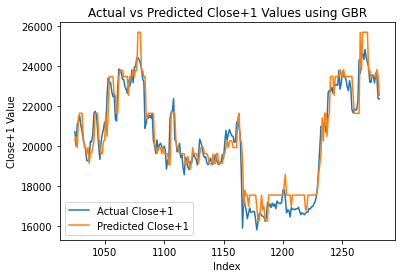

In [31]:
# Plot the results on a labelled graph
plt.plot(df['Close+1'], label='Actual Close+1')
plt.plot(df['Predicted Close+1'], label='Predicted Close+1')
plt.xlabel('Index')
plt.ylabel('Close+1 Value')
plt.title('Actual vs Predicted Close+1 Values using GBR')
plt.legend()
plt.show()

**Now I will test the model on new data**

In [38]:
#Making a new request to Lunar to get new data
# Get the Unix timestamp for the current time - 2 weeks
two_weeks_ago = int(time.time()) - 14*24*60*60

# Build the API request URL
url = f"https://lunarcrush.com/api3/coins/1/time-series?interval=all&start={two_weeks_ago}&bucket=day&data_points=14"
password = os.getenv("lunar_api")
headers = {
   'Authorization': password }


# Send the request and store the response as a DataFrame
response = requests.get(url, headers=headers)
data = response.json()
df_new = pd.DataFrame(data["timeSeries"])

# Extract the relevant columns (open and close) and rename them
df_new = df_new[['time', 'close', 'high']]
df_new.columns = ['date', 'close', 'high']

# Convert the date column to a datetime object and set it as the index
df_new['date'] = pd.to_datetime(df_new['date'], unit='s')
df_new = df_new.set_index('date')

#Creating a close+1 column which will be my Time target variable 
df_new['close+1'] = df_new['close'].shift(-1)

df_new = df_new.drop(df_new.index[-1])

In [39]:
df_new

,close,high,close+1
date,,,
2023-03-03,22362.679332,23479.348094,22353.350074
2023-03-04,22353.350074,22405.176954,22435.514197
2023-03-05,22435.514197,22613.685231,22429.757533
2023-03-06,22429.757533,22584.293809,22219.769071
2023-03-07,22219.769071,22527.418642,21718.079830
2023-03-08,21718.079830,22268.896252,20363.021112
2023-03-09,20363.021112,21802.716681,20187.243648
2023-03-10,20187.243648,20370.595398,20632.409629
2023-03-11,20632.409629,20792.525692,22163.949952


In [40]:
# predict the close+1 with the new data
df_new['predicted_close+1'] = model.predict(df_new[['close', 'high']])

/Users/tom/miniconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


KeyError: ('close', 'high')

In [41]:
df_new

,close,high,close+1,predicted_close+1
date,,,,
2023-03-03,22362.679332,23479.348094,22353.350074,22532.412441
2023-03-04,22353.350074,22405.176954,22435.514197,21630.617381
2023-03-05,22435.514197,22613.685231,22429.757533,21630.617381
2023-03-06,22429.757533,22584.293809,22219.769071,21630.617381
2023-03-07,22219.769071,22527.418642,21718.079830,21630.617381
2023-03-08,21718.079830,22268.896252,20363.021112,21630.617381
2023-03-09,20363.021112,21802.716681,20187.243648,20145.287052
2023-03-10,20187.243648,20370.595398,20632.409629,19916.026247
2023-03-11,20632.409629,20792.525692,22163.949952,20248.220625


In [46]:
# Calculate mean squared error (MSE)
mse = mean_squared_error(df_new['close+1'], df_new['predicted_close+1'])

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(df_new['close+1'], df_new['predicted_close+1'])

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(np.abs((df_new['close+1'] - df_new['predicted_close+1']) / df_new['close+1'])) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

MSE: 1348390.27
RMSE: 1161.20
MAE: 934.69
MAPE: 4.08%


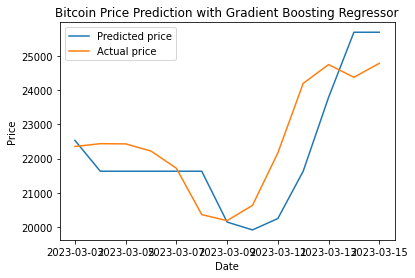

In [47]:
# Plot the predicted and actual prices
plt.plot(df_new.index, df_new['predicted_close+1'], label='Predicted price')
plt.plot(df_new.index, df_new['close+1'], label='Actual price')

# Add axis labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction with Gradient Boosting Regressor')

# Add a legend
plt.legend()

# Show the plot
plt.show()


**Using Prophet**

In [63]:
data = pd.read_csv('./data/data_complete_final.csv').drop(['market_cap', 'market_cap_global'], axis=1)

In [64]:
# select all features except the target variable
X = data.drop(['date', 'close+1'], axis=1)

In [66]:
# select the target variable
y = data['close+1']

In [67]:
# feature selection with k-best
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=5)
selector.fit(X, y)

SelectKBest(k=5, score_func=<function f_regression at 0x7fd1ac0c6b80>)

In [68]:
# get the selected features
selected_features = X.columns[selector.get_support()].tolist()

In [69]:
selected_features

['open', 'close', 'high', 'low', 'sma_50']

In [70]:
# use the selected features
data = data[['date', 'close+1'] + selected_features]

In [71]:
# convert date column to datetime format
data['date'] = pd.to_datetime(data['date'])

In [72]:
# rename the columns
data = data.rename(columns={'date': 'ds', 'close+1': 'y'})

In [73]:
# train-test split
train_data = data.iloc[:-30, :]
test_data = data.iloc[-30:, :]

In [79]:
# create and fit the model
from prophet import Prophet
model = Prophet()
model.fit(train_data)

16:43:19 - cmdstanpy - INFO - Chain [1] start processing
16:43:19 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
# make predictions
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

In [81]:
# extract the predicted values
predicted_values = forecast.iloc[-30:, :]['yhat']

In [82]:
# calculate the performance metrics
mse = ((predicted_values - test_data['y']) ** 2).mean()
rmse = np.sqrt(mse)
mae = abs(predicted_values - test_data['y']).mean()
mape = (abs(predicted_values - test_data['y']) / test_data['y']).mean() * 100

In [83]:
print(f'RMSE: {rmse:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')


RMSE: 1133.75
MSE: 1285395.62
MAE: 1011.59
MAPE: 4.34%


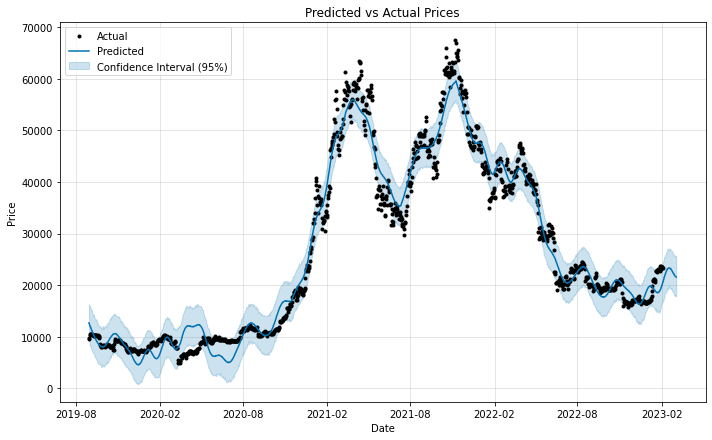

In [84]:
# plot the predictions
fig = model.plot(forecast)

# add labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend(['Actual', 'Predicted', 'Confidence Interval (95%)'], loc='upper left')
plt.show()

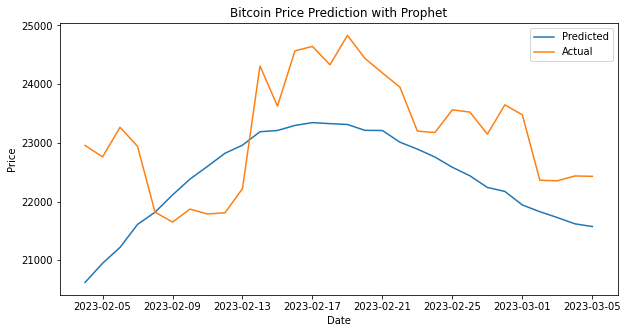

In [85]:
# plot the recent 30-day period and the 30-day prediction period
last_30_days = forecast.iloc[-30:, :]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(last_30_days['ds'], last_30_days['yhat'], label='Predicted')
ax.plot(test_data['ds'].iloc[-30:], test_data['y'].iloc[-30:], label='Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Bitcoin Price Prediction with Prophet')
ax.legend()
plt.show()


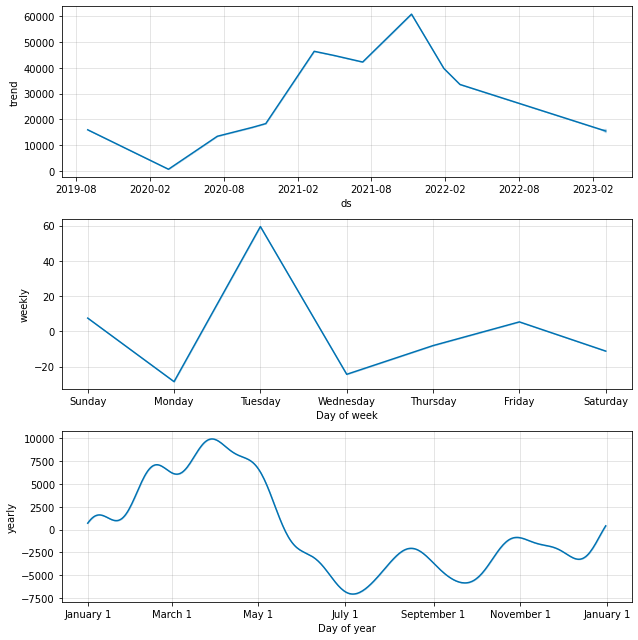

In [259]:
# plot the components
fig2 = model.plot_components(forecast)

**Testing Prophet with new data:**

In [93]:
# Get the Unix timestamp for the current time - 2 weeks
two_weeks_ago = int(time.time()) - 14*24*60*60

# Build the API request URL
url = f"https://lunarcrush.com/api3/coins/1/time-series?interval=all&start={two_weeks_ago}&bucket=day&data_points=14"
password = os.getenv("lunar_api")
headers = {
   'Authorization': password }

# Send the request and store the response as a DataFrame
response = requests.get(url, headers=headers)
data = response.json()
df_new = pd.DataFrame(data["timeSeries"])

# Extract the relevant columns (open, close, high, low, and sma_50) and rename them
df_new = df_new[['time', 'close', 'open', 'high', 'low', 'sma_50']]
df_new.columns = ['date', 'close', 'open', 'high', 'low', 'sma_50']

# Convert the date column to a datetime object and set it as the index
df_new['date'] = pd.to_datetime(df_new['date'], unit='s')
df_new = df_new.set_index('date')

#Creating a close+1 column which will be my Time target variable 
df_new['close+1'] = df_new['close'].shift(-1)

df_new = df_new.drop(df_new.index[-1])

df_new = df_new.reset_index()


df_new['ds'] = pd.to_datetime(df_new['date'])

df_new = df_new.drop('date', axis=1)


In [94]:
df_new

,close,open,high,low,sma_50,close+1,ds
0,22362.679332,23476.633731,23479.348094,22213.237594,22872.902606,22353.350074,2023-03-03
1,22353.350074,22362.923027,22405.176954,22198.981009,22921.778114,22435.514197,2023-03-04
2,22435.514197,22354.143598,22613.685231,22307.143313,22950.962403,22429.757533,2023-03-05
3,22429.757533,22436.816776,22584.293809,22331.314828,22981.941569,22219.769071,2023-03-06
4,22219.769071,22428.322390,22527.418642,22011.262497,23002.944295,21718.079830,2023-03-07
5,21718.079830,22216.442321,22268.896252,21708.050506,23014.075507,20363.021112,2023-03-08
6,20363.021112,21720.079318,21802.716681,20210.306747,23007.560315,20187.243648,2023-03-09
7,20187.243648,20367.001777,20370.595398,19628.254309,22989.569322,20632.409629,2023-03-10
8,20632.409629,20187.877075,20792.525692,20068.660312,22948.686479,22163.949952,2023-03-11
9,22163.949952,20628.029034,22185.031111,20448.806261,22936.412962,24197.532998,2023-03-12


In [95]:
# make predictions on new data
future = model.make_future_dataframe(periods=len(df_new))
forecast = model.predict(future)

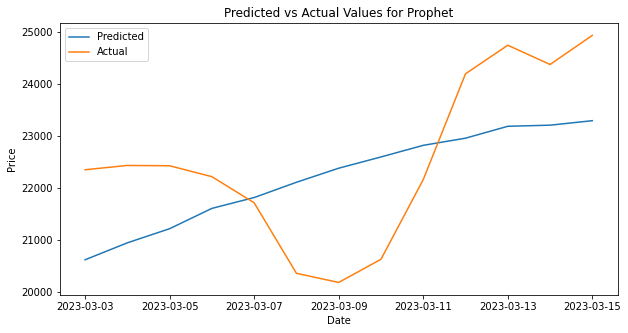

In [96]:
# make predictions on new data
future = model.make_future_dataframe(periods=len(df_new))
forecast = model.predict(future)

# extract the predicted values for the new data
predicted_values = forecast.iloc[-len(df_new):, :]['yhat']

# plot the predicted vs actual values for the new data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_new['ds'], predicted_values, label='Predicted')
ax.plot(df_new['ds'], df_new['close+1'], label='Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Predicted vs Actual Values for Prophet')
ax.legend()
plt.show()

In [97]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

# calculate MAPE
mape = mean_absolute_percentage_error(df_new['close+1'], predicted_values)
print(f"MAPE: {round(mape*100, 2)}%")

# calculate MSE
mse = mean_squared_error(df_new['close+1'], predicted_values)
print(f"MSE: {round(mse, 2)}")

# calculate RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {round(rmse, 2)}")

# calculate R2
r2 = r2_score(df_new['close+1'], predicted_values)
print(f"R2: {round(r2, 2)}")


MAPE: 5.98%
MSE: 2095243.52
RMSE: 1447.5
R2: 0.14
